In [85]:
# importing libraries
import matplotlib
import pandas as pd
import numpy as np
import tweepy
import requests
%matplotlib inline

## Gathering
#### Reading twitter-archive-enhanced.csv from hard disk

In [2]:
# Read WeRateDogs Twitter archive
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv")

#### Reading image-predictions.tsv from URL

In [4]:
# Downloading image-predictions.tsv
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open("./image_predictions.tsv", "wb") as file:
    file.write(response.content)

In [3]:
# Read image_predictions.tsv
image_predictions = pd.read_csv("image_predictions.tsv", sep="\t")

#### Get additional data from the Twitter API Tweepy library.

In [7]:
CONSUMER_KEY = "CONSUMER_KEY"
CONSUMER_SECRET = "CONSUMER_SECRET"
OAUTH_TOKEN = "OAUTH_TOKEN"
OAUTH_TOKEN_SECRET = "OAUTH_TOKEN_SECRET"

> tweepy instructions http://docs.tweepy.org/en/3.7.0/getting_started.html#api

In [8]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)

In [9]:
# testing one tweet
tweet = api.get_status(666049248165822465, 
                       tweet_mode='extended', 
                       wait_on_rate_limit = True, 
                       wait_on_rate_limit_notify = True)._json
print(tweet)

{'created_at': 'Mon Nov 16 00:24:50 +0000 2015', 'id': 666049248165822465, 'id_str': '666049248165822465', 'full_text': 'Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq', 'truncated': False, 'display_text_range': [0, 120], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 666049244999131136, 'id_str': '666049244999131136', 'indices': [97, 120], 'media_url': 'http://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg', 'url': 'https://t.co/4B7cOc1EDq', 'display_url': 'pic.twitter.com/4B7cOc1EDq', 'expanded_url': 'https://twitter.com/dog_rates/status/666049248165822465/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 510, 'h': 680, 'resize': 'fit'}, 'large': {'w': 768, 'h': 1024, 'resize': 'fit'}, 'medium': {'w': 768, 'h': 1024, 'resize': 'fit'}}}]}, 'extended_enti

In [13]:
# list to store results
df_tweet_api = []
# list to catch errors
error_list = []

# loop through all the tweets in twitter-archive-enhanced.csv
for each_tweet_id in twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(666049248165822465, 
                       tweet_mode='extended', 
                       wait_on_rate_limit = True, 
                       wait_on_rate_limit_notify = True)._json
        df_tweet_api.append({'tweet_id': each_tweet_id,
                             'favorite_count': tweet['favorite_count'],
                             'retweet_count': tweet['retweet_count'],
                             'user_id': tweet['user']['id'],
                             'user_screen_name': tweet['user']['screen_name']})
    except Exception as e:
        print(str(each_tweet_id)+ " _ " + str(e))
        error_list.append(each_tweet_id)

Rate limit reached. Sleeping for: 192
Rate limit reached. Sleeping for: 689
Rate limit reached. Sleeping for: 684


In [56]:
# double checking from errors while retrieving API data
error_list

[]

In [14]:
# Moving list to pandas DataFrame
df_tweets = pd.DataFrame(df_tweet_api, columns = ['tweet_id','favorite_count','retweet_count','user_id','user_screen_name'])
# Save DataFrame in file
df_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [4]:
# Read the saved tweet_json.txt file into a dataframe
df_tweet_data = pd.read_csv('tweet_json.txt', encoding = 'utf-8')

## Assesing
#### Quality
##### `image_predictions` table
- 1) Some images are used in more than one tweet, this should be considered duplicated data because they refer to the same dog.
- 2) We will not use the prediction information so all prediction related information will be dropped

##### `twitter_archive` table
- 1) The following columns should be data type integer and not float: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id. retweeted_status_timestamp should be timestamp and not string. These columns will be removed for tidiness so there is no need to convert their data types.
- 1b) tweet_id should have data type object and not integer or float.
- 2) The timestamp should have data type timestamp and not string.
- 3) Fix rating numerstor and denominator.
- 4) Some tweets have no associated image in `image_predictions` table, these are retweets that will be removed from the DataFrame
- 4b) Tweets with text starting as "RT @" are retweets, these will be removed from the dataset.
- 5) Tweets with no dog name (name = None), depending on the analisys to do this may not matter but I choose to focus on tweets where the dog name is present
- 6) Some dog names are less than 3 letters long, names less than 3 letters long starting in lowercase will be dropped
- 7) Some expanded URLs are empty, this column doesn't provide any additional data because is formed by "https://twitter.com/dog_rates/status/" concatenated with the tweet id, I will drop this column
- 8) Some dogs have 2 stages, doggo and pupper. I will assign doggo to these dogs.
- 9) Columns regarding retweet information are not needed and will be dropped, these columns are: retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp

##### `df_tweet_data` table
- 1) All tweets come from the same user so columns user_id and user_screen_name are not needed and will be dropped

#### Tidiness
##### `twitter_archive` table
- 1) The 4 different columns doggo, floofer, pupper and puppo, are all relative to the same variable that identifies the stage of dog. So I will melt these columns into a single column named "stage".

##### `all tables` table
- 1) The df_tweet_data_clean and image_predictions_clean are part of the same observational unit as twitter_archive_clean but there are three separate tables so I will merge all 3 dataframes into twitter_archive_clean and save it in twitter_archive_master.csv.


In [6]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [7]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [10]:
# checking for null values
image_predictions.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [11]:
# checking for duplicate records
image_predictions.duplicated().any()

False

In [12]:
# checking for duplicate images
image_predictions['jpg_url'].duplicated().sum()

66

In [13]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [14]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [15]:
# checking for duplicated records
twitter_archive.duplicated().any()

False

In [16]:
# checking for invalid numerator values
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [17]:
# checking for invalid denominator values
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [18]:
# checking for retweets (tweets without images)
twitter_archive[~twitter_archive.tweet_id.isin(image_predictions['tweet_id'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
42,884247878851493888,NaN,NaN,2017-07-10 03:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,NaN,NaN,NaN,https://twitter.com/kaijohnson_19/status/88396...,13,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
72,878604707211726852,NaN,NaN,2017-06-24 13:24:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Martha is stunning how h*ckin dare you. 13/10 ...,NaN,NaN,NaN,https://twitter.com/bbcworld/status/8785998685...,13,10,None,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None


In [19]:
# Tweets with no dog name
twitter_archive[~twitter_archive.tweet_id.isin(image_predictions['tweet_id'])][twitter_archive['name']=='None']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
42,884247878851493888,NaN,NaN,2017-07-10 03:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,NaN,NaN,NaN,https://twitter.com/kaijohnson_19/status/88396...,13,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
72,878604707211726852,NaN,NaN,2017-06-24 13:24:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Martha is stunning how h*ckin dare you. 13/10 ...,NaN,NaN,NaN,https://twitter.com/bbcworld/status/8785998685...,13,10,None,None,None,None,None
83,876537666061221889,NaN,NaN,2017-06-18 20:30:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I can say with the pupmost confidence that the...,NaN,NaN,NaN,https://twitter.com/mpstowerham/status/8761629...,14,10,None,None,None,None,None
88,875097192612077568,NaN,NaN,2017-06-14 21:06:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You'll get your package when that precious man...,NaN,NaN,NaN,https://twitter.com/drboondoc/status/874413398...,13,10,None,None,None,None,None
101,872668790621863937,NaN,NaN,2017-06-08 04:17:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @loganamnosis: Penelope here is doing me qu...,8.726576e+17,1.547674e+08,2017-06-08 03:32:35 +0000,https://twitter.com/loganamnosis/status/872657...,14,10,None,None,None,None,None


In [20]:
# checkin for invalid values in columns doggo, floofer, pupper and puppo
print(twitter_archive['doggo'].value_counts())
print(twitter_archive['floofer'].value_counts())
print(twitter_archive['pupper'].value_counts())
print(twitter_archive['puppo'].value_counts())

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


In [21]:
# checking for short names (less than 3 letters)
twitter_archive[twitter_archive['name'].apply(len) < 3]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
393,825876512159186944,NaN,NaN,2017-01-30 01:21:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mo. No one will push him around in the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/825876512...,11,10,Mo,None,None,None,None
446,819015337530290176,NaN,NaN,2017-01-11 02:57:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo. He was a very good ...,8.190048e+17,4.196984e+09,2017-01-11 02:15:36 +0000,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
449,819004803107983360,NaN,NaN,2017-01-11 02:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
553,804026241225523202,NaN,NaN,2016-11-30 18:16:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's going to make me cry. 13/10 p...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/804026241...,13,10,Bo,None,None,None,None
583,800188575492947969,NaN,NaN,2016-11-20 04:06:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo. He's a Benedoop Cum...,6.816941e+17,4.196984e+09,2015-12-29 04:31:49 +0000,https://twitter.com/dog_rates/status/681694085...,11,10,Bo,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
679,789137962068021249,NaN,NaN,2016-10-20 16:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's a West Congolese Bugaboop Snu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/789137962...,12,10,Bo,None,None,None,None
686,788070120937619456,NaN,NaN,2016-10-17 17:32:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo and Ty. Bo eats pape...,7.610045e+17,4.196984e+09,2016-08-04 01:03:17 +0000,https://twitter.com/dog_rates/status/761004547...,11,10,Bo,None,None,None,None
759,778396591732486144,NaN,NaN,2016-09-21 00:53:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is an East African Chalupa...,7.030419e+17,4.196984e+09,2016-02-26 02:20:37 +0000,https://twitter.com/dog_rates/status/703041949...,10,10,an,None,None,None,None


In [22]:
twitter_archive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [23]:
df_tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 5 columns):
tweet_id            2356 non-null int64
favorite_count      2356 non-null int64
retweet_count       2356 non-null int64
user_id             2356 non-null int64
user_screen_name    2356 non-null object
dtypes: int64(4), object(1)
memory usage: 92.1+ KB


In [24]:
df_tweet_data.head()

,tweet_id,favorite_count,retweet_count,user_id,user_screen_name
0,892420643555336193,105,42,4196983835,dog_rates
1,892177421306343426,105,42,4196983835,dog_rates
2,891815181378084864,105,42,4196983835,dog_rates
3,891689557279858688,105,42,4196983835,dog_rates
4,891327558926688256,105,42,4196983835,dog_rates


In [25]:
df_tweet_data['tweet_id'].duplicated().any()

False

In [26]:
df_tweet_data.isnull().sum().any()

False

## Cleaning
#### copying dataframes

In [109]:
df_tweet_data_clean = df_tweet_data.copy()
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()

#### Define
tweet_id should have data type object and not integer or float.

#### Code

In [110]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
df_tweet_data_clean['tweet_id'] = df_tweet_data_clean['tweet_id'].astype(str)
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)

#### Test

In [111]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

In [112]:
df_tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 5 columns):
tweet_id            2356 non-null object
favorite_count      2356 non-null int64
retweet_count       2356 non-null int64
user_id             2356 non-null int64
user_screen_name    2356 non-null object
dtypes: int64(3), object(2)
memory usage: 92.1+ KB


In [113]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### Define
Some images are used in more than one tweet, this should be considered duplicated data because they refer to the same dog.

#### Code

In [114]:
image_predictions_clean.jpg_url.drop_duplicates(inplace=True)

#### Test

In [115]:
image_predictions_clean['jpg_url'].duplicated().any()

False

#### Define
Tweets with text starting as "RT @" are retweets, these will be removed from the dataset.

#### Code

In [116]:
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean.text.str.contains( r"RT @")]

#### Test

In [117]:
twitter_archive_clean[twitter_archive_clean.text.str.contains( r"RT @")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define
We will not use the prediction information so all prediction related information will be dropped, also img_num will be dropped

#### Code

In [118]:
image_predictions_clean.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'img_num'], axis=1, inplace=True)

#### Test

In [119]:
image_predictions_clean.head()

,tweet_id,jpg_url
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg


#### Define
All tweets come from the same user so columns user_id and user_screen_name are not needed and will be dropped

#### Code

In [120]:
df_tweet_data_clean.drop(['user_id', 'user_screen_name'], axis=1, inplace=True)

#### Test

In [121]:
df_tweet_data_clean.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,105,42
1,892177421306343426,105,42
2,891815181378084864,105,42
3,891689557279858688,105,42
4,891327558926688256,105,42


#### Define
Fix rating numerstor and denominator.

#### Code

In [122]:
pd.set_option('max_colwidth', 200)
twitter_archive_clean.text

0                                                                This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1           This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
2                            This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
3                                                                      This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
4           This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f
5           Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG

In [123]:
# Find records with more than one #/# in 'text' field
correct_ratings = twitter_archive_clean[twitter_archive_clean.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")][['tweet_id','text']]
correct_ratings[['rating_numerator','rating_denominator']] = correct_ratings.text.str.extract( r"(\d+\.?\d*\/\d+\.?\d*\D+)(?P<numerator>\d+)(\/)(?P<denominator>\d+)")[['numerator','denominator']]
twitter_archive_clean.update(correct_ratings)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


#### Test

In [124]:
twitter_archive_clean[twitter_archive_clean.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")][['tweet_id','text','rating_numerator','rating_denominator']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,tweet_id,text,rating_numerator,rating_denominator
55,881633300179243008,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,13,10
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",13,10
766,777684233540206592,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",11,10
1007,747600769478692864,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,7,10
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14,10
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,13,10
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11,10
1222,714258258790387713,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE,8,10
1359,703356393781329922,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf,2,10
1459,695064344191721472,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",13,10


#### Define
Some tweets have no associated image in `image_predictions` table, these are retweets that will be removed from the DataFrame

#### Code

In [125]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.tweet_id.isin(image_predictions_clean['tweet_id'])]

#### Test

In [126]:
twitter_archive_clean[~twitter_archive_clean.tweet_id.isin(image_predictions_clean['tweet_id'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define
Tweets with no dog name (name = None), depending on the analisys to do this may not matter but I choose to focus on tweets where the dog name is present

#### Code

In [127]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['name']!='None']

#### Test

In [128]:
twitter_archive_clean[twitter_archive_clean['name']=='None']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define
Some dog names are less than 3 letters long, names less than 3 letters long starting in lowercase will be dropped

#### Code

In [129]:
twitter_archive_clean.drop(twitter_archive_clean[twitter_archive_clean['name'].apply(len) < 3][~twitter_archive_clean.name.str.contains( r"([A-Z])")].index,inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


#### Test

In [130]:
twitter_archive_clean[twitter_archive_clean['name'].apply(len) < 3][~twitter_archive_clean.name.str.contains( r"([A-Z])")]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define
The following columns should be data type integer and not float: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id. retweeted_status_timestamp should be timestamp and not string. These columns will be removed for tidiness so there is no need to convert their data types.

#### Code

In [131]:
twitter_archive_clean.drop(['in_reply_to_status_id', 
                            'in_reply_to_user_id', 
                            'retweeted_status_id', 
                            'retweeted_status_user_id', 
                            'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

#### Test

In [132]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


#### Define
Some expanded URLs are empty, this column doesn't provide any additional data because is formed by "https://twitter.com/dog_rates/status/" concatenated with the tweet id, I will drop this column

#### Code

In [133]:
twitter_archive_clean.drop(['expanded_urls'], axis=1, inplace=True)

#### Test

In [134]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10,Franklin,None,None,None,None


#### Define
The timestamp should have data type timestamp and not string.

#### Code

In [135]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean.timestamp)

#### Test

In [136]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 2346
Data columns (total 11 columns):
tweet_id              1385 non-null object
timestamp             1385 non-null datetime64[ns]
source                1385 non-null object
text                  1385 non-null object
rating_numerator      1385 non-null object
rating_denominator    1385 non-null object
name                  1385 non-null object
doggo                 1385 non-null object
floofer               1385 non-null object
pupper                1385 non-null object
puppo                 1385 non-null object
dtypes: datetime64[ns](1), object(10)
memory usage: 169.8+ KB


#### Define
The 4 different columns doggo, floofer, pupper and puppo, are all relative to the same variable that identifies the stage of dog. So I will melt these columns into a single column named "stage".

#### Code

In [137]:
twitter_archive_clean['stage'] = twitter_archive_clean[['doggo', 'floofer','pupper','puppo']].apply(lambda stages: ','.join(temp_stage for temp_stage in stages if temp_stage!="None"), axis=1)
twitter_archive_clean.loc[twitter_archive_clean.stage == '', 'stage'] = np.nan
twitter_archive_clean.drop(['doggo', 'floofer','pupper','puppo'], axis=1, inplace=True)
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10,Franklin,NaN


#### Test

In [138]:
twitter_archive_clean['stage'].value_counts()

pupper          122
doggo            38
puppo            15
doggo,pupper      5
floofer           5
Name: stage, dtype: int64

#### Define
The df_tweet_data_clean and image_predictions_clean are part of the same observational unit as twitter_archive_clean but there are three separate tables so I will merge all 3 dataframes into twitter_archive_clean and save it in twitter_archive_master.csv.

#### Code

In [139]:
twitter_archive_clean = pd.merge(left=twitter_archive_clean,
                                 right=df_tweet_data_clean, 
                                 left_on='tweet_id', 
                                 right_on='tweet_id', 
                                 how='inner')

In [140]:
twitter_archive_clean = pd.merge(left=twitter_archive_clean,
                                 right=image_predictions_clean, 
                                 left_on='tweet_id', 
                                 right_on='tweet_id', 
                                 how='inner')

#### Test

In [141]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,stage,favorite_count,retweet_count,jpg_url
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,NaN,105,42,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,NaN,105,42,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,NaN,105,42,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,NaN,105,42,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10,Franklin,NaN,105,42,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg


## Storing clean data

In [142]:
twitter_archive_clean.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index=False)

## Analysis

In [143]:
# Loading data
df = pd.read_csv('twitter_archive_master.csv')

In [155]:
df.head(3)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,stage,favorite_count,retweet_count,jpg_url
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,NaN,105,42,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,NaN,105,42,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,NaN,105,42,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg


In [154]:
df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1360
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       16
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>       9
Name: source, dtype: int64

In [156]:
df['name'].value_counts()

Charlie       11
Cooper        10
Lucy          10
Oliver        10
Penny          9
Tucker         9
Winston        8
Sadie          8
Daisy          7
the            7
Lola           7
Toby           7
Jax            6
Koda           6
Bella          6
Stanley        6
Bo             6
Louis          5
Leo            5
Dave           5
Buddy          5
Rusty          5
Oscar          5
Milo           5
Chester        5
Bailey         5
Scout          5
Finn           4
Brody          4
one            4
              ..
Bonaparte      1
Kanu           1
Lolo           1
Chesney        1
Rufio          1
Emmy           1
Jett           1
Geno           1
Dug            1
Dwight         1
Billy          1
officially     1
Travis         1
Tanner         1
O              1
Eriq           1
Deacon         1
Caryl          1
Dewey          1
Marlee         1
Ruffles        1
Ralf           1
Snoopy         1
Jordy          1
Grey           1
Charl          1
Bluebert       1
Swagger       

In [146]:
df['favorite_count'].value_counts()

105    1385
Name: favorite_count, dtype: int64

In [147]:
df['retweet_count'].value_counts()

42    1385
Name: retweet_count, dtype: int64

## What is the most common dog stage?

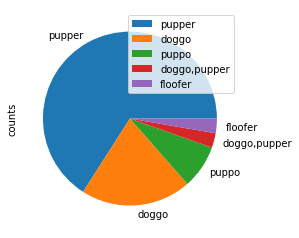

In [145]:
stage = df[df['stage'] != 'None']['stage'].value_counts().reset_index(name='counts')
stage.columns = ['unique_values', 'counts']
stage.plot(kind='pie',x='unique_values', y='counts', labels=stage['unique_values']);

#### The most common dog stage is pupper, followed by doggo
#### Stage vs Rating

In [148]:
df_rating = df.copy()
df_rating['rating']=df_rating['rating_numerator']/df_rating['rating_denominator']
stage_rate = df_rating[df_rating['stage'] != 'None'].groupby('stage').mean()[['rating']].reset_index()
stage_rate

,stage,rating
0,doggo,1.207895
1,"doggo,pupper",1.180000
2,floofer,1.160000
3,pupper,1.037705
4,puppo,1.180000


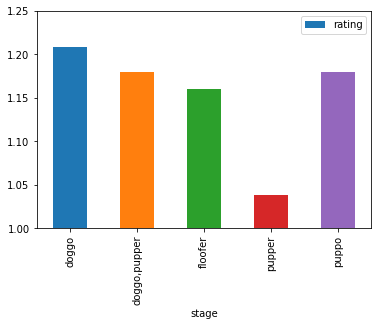

In [149]:
stage_rate.plot(kind='bar', x='stage', y='rating', ylim=(1.0,1.25));

#### The highest rated dogs belong to the doggo stage
#### Rating evolution over time

In [153]:
df['rating_denominator'].value_counts()

10     1383
170       1
7         1
Name: rating_denominator, dtype: int64

In [150]:
rate_vs_time = df_rating[['timestamp','rating_numerator','rating_denominator','rating']]
rate_vs_time['date'] = pd.to_datetime(rate_vs_time.timestamp)
rate_vs_time['date'] = rate_vs_time['date'].dt.date
rate_vs_time.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,timestamp,rating_numerator,rating_denominator,rating,date
0,2017-08-01 16:23:56,13,10,1.3,2017-08-01
1,2017-08-01 00:17:27,13,10,1.3,2017-08-01
2,2017-07-31 00:18:03,12,10,1.2,2017-07-31
3,2017-07-30 15:58:51,13,10,1.3,2017-07-30
4,2017-07-29 16:00:24,12,10,1.2,2017-07-29


In [151]:
rate_vs_time2 = rate_vs_time.groupby('date').mean()[['rating_numerator','rating_denominator','rating']].reset_index()
rate_vs_time2.head()

,date,rating_numerator,rating_denominator,rating
0,2015-11-16,9.000000,10.0,0.900000
1,2015-11-17,8.285714,10.0,0.828571
2,2015-11-18,8.666667,10.0,0.866667
3,2015-11-19,9.583333,10.0,0.958333
4,2015-11-20,8.900000,10.0,0.890000


(6, 14)

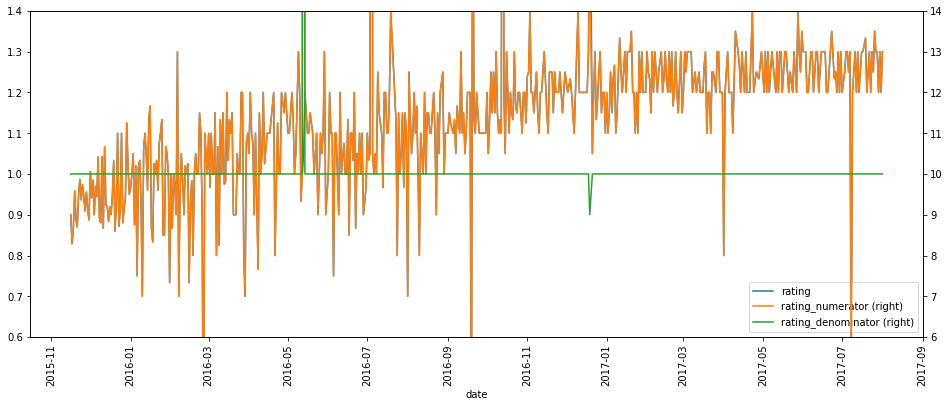

In [152]:
ax = rate_vs_time2.plot(x='date',y='rating',ylim=(0.6,1.4))
ax2 = rate_vs_time2.plot(x='date',y=['rating_numerator','rating_denominator'],secondary_y=True,ax=ax, rot=90, figsize=[16,6])
ax2.set_ylim(6, 14)

#### Most users have used 10 as rating denominator but, the rating numerator increased from an average of 9 up to 13 until January 2017 when this value estabilized between 12 and 13, the rating followed the same pattern as the rating numerator.
## Summary of findings
- The most common dog stage in this data set is pupper
- The column ‘source’ sows that most pictures are uploaded from an iPhone.
- The most common name is Charlie.
- The highest rated dogs belong to the doggo stage
- Most users have used 10 as rating denominator but, the rating numerator increased from an average of 9 up to 13 until January 2017 when this value stabilized between 12 and 13, the rating followed the same pattern as the rating numerator.